In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import model_selection, preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split



# Préparation des données

In [62]:
df = pd.read_csv('world-happiness-report-2021.csv')
#df.head()
#df.info()
#df.describe()

df2 = pd.read_csv('world-happiness-report.csv')
df2.head()

#Création liste des régions du monde par pays
country_region = df.iloc[:,0:2]

#Mise en forme des 2 datasets en prévision du concat
#dataset de 2021 :
df_1 = df.iloc[:,:12]
df_1 = df_1.drop(df.iloc[:,3:6], axis=1)
df_1 = df_1.drop('Regional indicator', axis=1)
df_1['year']='2021'

#dataset historique depuis 2005 :
df_2 = df2.iloc[:, :-2]
dico = {'Life Ladder' : 'Ladder score', 'Log GDP per capita' : 'Logged GDP per capita', 'Healthy life expectancy at birth' : 'Healthy life expectancy'}
df_2.rename(dico, axis=1, inplace=True)

#création du fichier contenants les données depuis 2005 :
df_full = pd.concat([df_1, df_2], axis=0)
df_full['year'] = df_full['year'].astype('int')
df_full = df_full.sort_values(by='Country name', ascending=True)

#ajout colonne Region d'après le df country_region créé précédemment :
df_full = df_full.merge(country_region, on = 'Country name', how ='inner')

#ajout du rank par année de chaque pays
df_full["rank"] = df_full.groupby("year")["Ladder score"].rank("dense", ascending=False).astype('int')

df_full.head()
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2035 entries, 0 to 2034
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country name                  2035 non-null   object 
 1   Ladder score                  2035 non-null   float64
 2   Logged GDP per capita         2011 non-null   float64
 3   Social support                2026 non-null   float64
 4   Healthy life expectancy       1984 non-null   float64
 5   Freedom to make life choices  2005 non-null   float64
 6   Generosity                    1959 non-null   float64
 7   Perceptions of corruption     1931 non-null   float64
 8   year                          2035 non-null   int32  
 9   Regional indicator            2035 non-null   object 
 10  rank                          2035 non-null   int32  
dtypes: float64(7), int32(2), object(2)
memory usage: 174.9+ KB


# SVM sur df_full

In [63]:
df_full = df_full.sort_values(['year', 'Country name'])
df_full.head()

,Country name,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,year,Regional indicator,rank
68,Australia,7.341,10.659,0.968,71.4,0.935,NaN,0.390,2005,North America and ANZ,5
159,Belgium,7.262,10.745,0.935,69.9,0.924,NaN,0.598,2005,Western Europe,6
226,Brazil,6.637,9.438,0.883,63.3,0.882,NaN,0.745,2005,Latin America and Caribbean,13
319,Canada,7.418,10.652,0.962,71.3,0.957,0.256,0.503,2005,North America and ANZ,3
446,Czech Republic,6.439,10.324,0.919,67.0,0.865,NaN,0.901,2005,Central and Eastern Europe,17


In [64]:
#Remplacement des NaN par les moyennes des variables en fonction de chaque pays
for i in df_full.iloc[:,2:8].columns : 
    df_full[i] = df_full[i].fillna(df_full.groupby('Country name')[i].transform("mean"))

In [65]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2035 entries, 68 to 2032
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country name                  2035 non-null   object 
 1   Ladder score                  2035 non-null   float64
 2   Logged GDP per capita         2035 non-null   float64
 3   Social support                2035 non-null   float64
 4   Healthy life expectancy       2035 non-null   float64
 5   Freedom to make life choices  2035 non-null   float64
 6   Generosity                    2035 non-null   float64
 7   Perceptions of corruption     2035 non-null   float64
 8   year                          2035 non-null   int32  
 9   Regional indicator            2035 non-null   object 
 10  rank                          2035 non-null   int32  
dtypes: float64(7), int32(2), object(2)
memory usage: 174.9+ KB


In [66]:
## variable cile

target_full = df_full['Ladder score']

#df pour la rl

col_feat = ['Logged GDP per capita', 'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption']


X_full = df_full[col_feat]

X_full



,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
68,10.659,0.968,71.400,0.935,0.266000,0.390
159,10.745,0.935,69.900,0.924,-0.035857,0.598
226,9.438,0.883,63.300,0.882,-0.077071,0.745
319,10.652,0.962,71.300,0.957,0.256000,0.503
446,10.324,0.919,67.000,0.865,-0.153000,0.901
...,...,...,...,...,...,...
1974,9.073,0.861,66.700,0.615,-0.169000,0.827
1988,8.973,0.850,68.034,0.940,-0.098000,0.796
1998,7.578,0.832,57.122,0.602,-0.147000,0.800
2017,8.145,0.708,55.809,0.782,0.061000,0.823


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_full, target_full, test_size=0.2, random_state=150)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)


# SVM

In [68]:
from sklearn.svm import SVR

Coef de détermination du modèle : 0.8936732765627577
Coef de détermination obtenu par cv : 0.8049147582874385
Score test : 0.8187785740750596


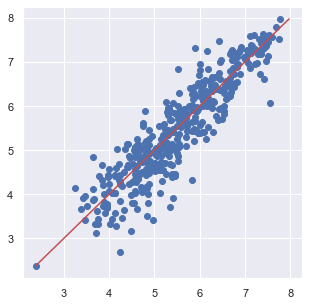

In [71]:
model = SVR(C=100)

model.fit(X_train_scaled, y_train)

print('Coef de détermination du modèle :', model.score(X_train_scaled, y_train))

print('Coef de détermination obtenu par cv :', cross_val_score(model, X_train_scaled, y_train).mean())

print('Score test :', model.score(X_test_scaled, y_test))

pred_test = model.predict(X_test_scaled)
pred_train = model.predict(X_train_scaled)
plt.figure(figsize=(5,5))
plt.scatter(pred_test, y_test)
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), c='r');

In [72]:
#RECHERCHE DES MEILLEURS PARAMETRES

parametres = {'C':[1,5,10,25,50,100], 'kernel':['rbf', 'linear'], 'gamma' : [0.001,0.1,0.5,1,10,100]}

grid_clf = model_selection.GridSearchCV(estimator=model, param_grid=parametres)

grille = grid_clf.fit(X_train_scaled, y_train)

print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']]) 
print(grid_clf.best_params_)


                                          params  mean_test_score
0      {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}         0.734598
1   {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}         0.734317
2        {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}         0.796616
3     {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}         0.734317
4        {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}         0.822309
..                                           ...              ...
67    {'C': 100, 'gamma': 1, 'kernel': 'linear'}         0.734247
68      {'C': 100, 'gamma': 10, 'kernel': 'rbf'}         0.480409
69   {'C': 100, 'gamma': 10, 'kernel': 'linear'}         0.734247
70     {'C': 100, 'gamma': 100, 'kernel': 'rbf'}         0.027283
71  {'C': 100, 'gamma': 100, 'kernel': 'linear'}         0.734247

[72 rows x 2 columns]
{'C': 5, 'gamma': 0.5, 'kernel': 'rbf'}


SVM avec application des best_params_

Coef de détermination du modèle : 0.92
Coef de détermination obtenu par cv : 0.83
Score test : 0.85


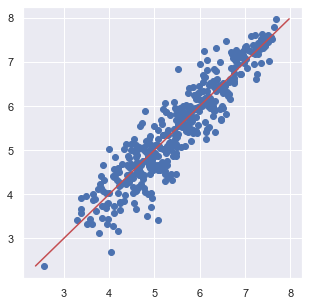

In [73]:
model = SVR(C=5, gamma=0.5, kernel='rbf')

model.fit(X_train_scaled, y_train)

print('Coef de détermination du modèle :', round(model.score(X_train_scaled, y_train),2))

print('Coef de détermination obtenu par cv :', round(cross_val_score(model, X_train_scaled, y_train).mean(),2))

print('Score test :', round(model.score(X_test_scaled, y_test),2))

pred_test = model.predict(X_test_scaled)
pred_train = model.predict(X_train_scaled)

plt.figure(figsize=(5,5))
plt.scatter(pred_test, y_test)
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), c='r');

In [74]:
# Fonction prédisant le score d'un pays d'après ses features

def score(model, GDP, social, life, choice, generosity, corruption) :
    x = np.array([GDP, social, life, choice, generosity, corruption]).reshape(1,6)
    x = scaler.transform(x)
    return model.predict(x)


GDP = 10.7
social = 0.962
life = 80
choice = 0.957
generosity = 0.256
corruption = 0.503

Happy_score = score(model, GDP, social, life, choice, generosity, corruption)

Happy_score


array([6.55858938])

In [75]:
df_scores_test = pd.DataFrame({'Ladder score' : y_test, 'Score prédit' : pred_test}, index = y_test.index)

df_scores_train = pd.DataFrame({'Ladder score' : y_train, 'Score prédit' : pred_train}, index = y_train.index)


In [76]:
df_scores = pd.concat([df_scores_test, df_scores_train], axis=0)

In [77]:
df_scores.drop('Ladder score', axis=1, inplace=True)

df_scores.head()

,Score prédit
1693,6.619868
1892,6.458965
1015,4.663807
940,4.711844
805,4.198797


In [78]:
df_full_score = df_full.merge(df_scores, how='left', left_index=True, right_index=True)

df_full_score.head()

,Country name,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,year,Regional indicator,rank,Score prédit
68,Australia,7.341,10.659,0.968,71.4,0.935,0.266000,0.390,2005,North America and ANZ,5,7.392995
159,Belgium,7.262,10.745,0.935,69.9,0.924,-0.035857,0.598,2005,Western Europe,6,6.880293
226,Brazil,6.637,9.438,0.883,63.3,0.882,-0.077071,0.745,2005,Latin America and Caribbean,13,5.835518
319,Canada,7.418,10.652,0.962,71.3,0.957,0.256000,0.503,2005,North America and ANZ,3,7.317834
446,Czech Republic,6.439,10.324,0.919,67.0,0.865,-0.153000,0.901,2005,Central and Eastern Europe,17,6.328542


In [79]:
df_full_score['diff_scores'] = abs(df_full_score['Score prédit'] - df_full_score['Ladder score'])

df_full_score.sort_values(by='diff_scores')



,Country name,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,year,Regional indicator,rank,Score prédit,diff_scores
1728,Sweden,7.496,10.790,0.970,71.90,0.905,0.141,0.2530,2010,Western Europe,4,7.495824,0.000176
143,Belarus,5.719,9.815,0.924,65.20,0.623,-0.091,0.6690,2015,Commonwealth of Independent States,57,5.718679,0.000321
459,Denmark,7.589,10.851,0.965,71.06,0.920,0.215,0.1700,2013,Western Europe,2,7.589366,0.000366
1257,Namibia,4.451,9.104,0.741,57.10,0.666,-0.104,0.8100,2020,Sub-Saharan Africa,88,4.450109,0.000891
1892,United Arab Emirates,6.458,11.053,0.827,67.50,0.942,0.060,0.3715,2020,Middle East and North Africa,27,6.458965,0.000965
...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,Egypt,5.541,9.135,0.686,59.82,0.609,-0.121,0.8239,2007,Middle East and North Africa,40,4.121083,1.419917
118,Bahrain,4.824,10.696,0.908,66.58,0.870,-0.051,0.5830,2011,Middle East and North Africa,95,6.326658,1.502658
691,Guinea,3.412,7.632,0.638,50.88,0.684,0.006,0.7050,2014,Sub-Saharan Africa,133,5.067197,1.655197
1117,Maldives,5.198,9.826,0.913,70.60,0.854,0.024,0.8250,2021,South Asia,87,6.854178,1.656178


In [80]:
regions_group = df_full_score.groupby(by='Regional indicator').agg(
    Ladder_score_mean = ('Ladder score', 'mean'), 
    GDP_mean = ('Logged GDP per capita', 'mean'),
    Social_support_mean = ('Social support', 'mean'),
    Healthy_life_mean = ('Healthy life expectancy', 'mean'),
    Life_choices_mean = ('Freedom to make life choices', 'mean'),
    Generosity_mean = ('Generosity', 'mean'),
    Perc_corruption_mean = ('Perceptions of corruption', 'mean'),
    rank_min = ('rank', 'min'),
    rank_max = ('rank', 'max'),
    Score_predit_mean = ('Score prédit', 'mean'),
    nb_pays = ('Country name', 'nunique')
) 

regions_group['diff_moy_reg'] = abs(regions_group['Score_predit_mean'] - regions_group['Ladder_score_mean'])

regions_group.sort_values(by='diff_moy_reg', inplace=True)

## Fonctionnement du modèle par Région du Monde
### Moyennes par région du monde / différence entre la moyenne du Ladder score et du score prédit

In [81]:
regions_group

,Ladder_score_mean,GDP_mean,Social_support_mean,Healthy_life_mean,Life_choices_mean,Generosity_mean,Perc_corruption_mean,rank_min,rank_max,Score_predit_mean,nb_pays,diff_moy_reg
Regional indicator,,,,,,,,,,,,
Western Europe,6.833096,10.770956,0.916904,72.195825,0.845154,0.066805,0.565707,1,96,6.839899,21,0.006804
Southeast Asia,5.345960,9.220936,0.810022,63.845728,0.866886,0.201139,0.730175,13,126,5.357692,9,0.011732
Commonwealth of Independent States,5.212835,9.251269,0.831456,63.305352,0.712397,-0.102055,0.772506,20,122,5.234959,12,0.022123
Middle East and North Africa,5.384469,9.692509,0.790107,64.557434,0.681605,-0.058448,0.724934,4,140,5.410190,17,0.025721
Central and Eastern Europe,5.557930,9.973784,0.856769,67.028529,0.685182,-0.091069,0.876975,15,124,5.594205,17,0.036275
North America and ANZ,7.254919,10.766823,0.938378,71.580968,0.903097,0.225344,0.450548,1,20,7.213926,4,0.040993
Sub-Saharan Africa,4.317688,7.987803,0.712984,53.138930,0.702902,-0.006483,0.787007,42,146,4.367863,36,0.050175
East Asia,5.645511,10.189265,0.850568,70.320261,0.756057,-0.027273,0.724170,16,92,5.701004,6,0.055493
South Asia,4.537363,8.333846,0.657846,59.793044,0.690429,0.075530,0.811725,23,147,4.648201,7,0.110839


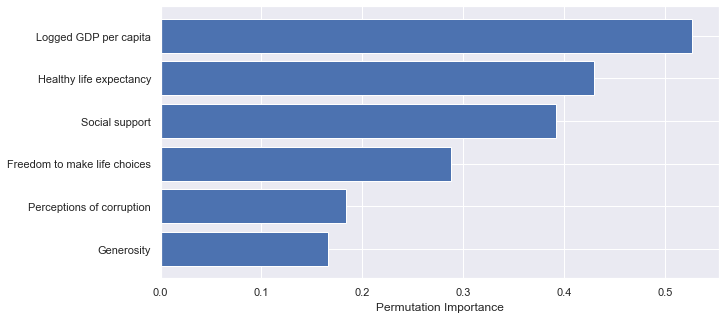

In [82]:

from sklearn.inspection import permutation_importance

Y = y_train
X = X_train_scaled

perm_importance = permutation_importance(model, X, Y, n_repeats=20, random_state=0)

features = np.array(col_feat)

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10,5))
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance");

## Région par région

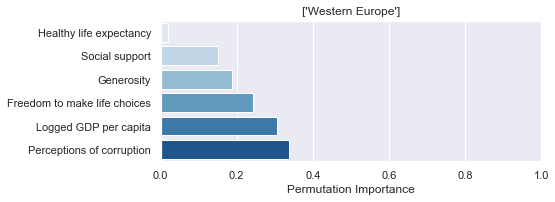

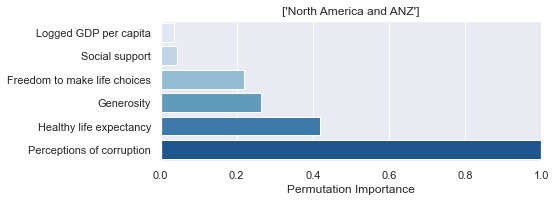

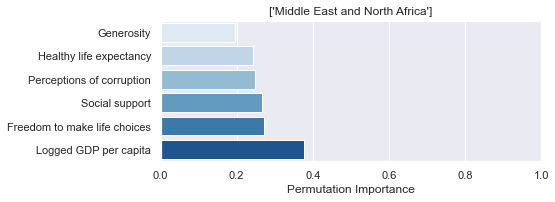

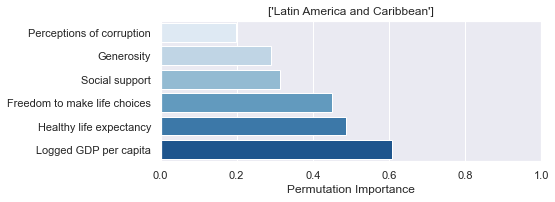

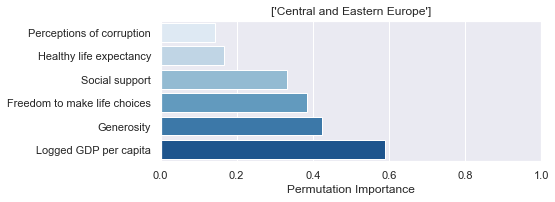

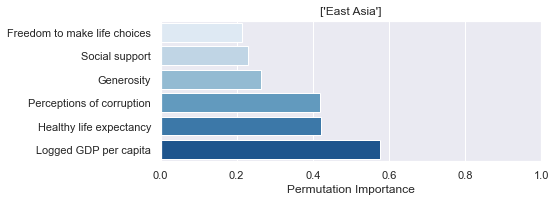

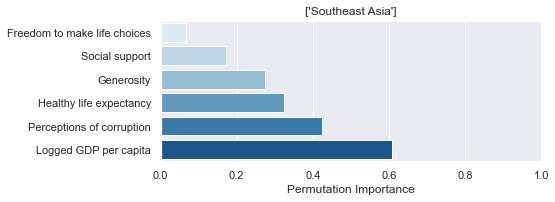

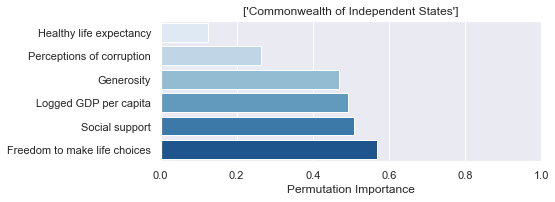

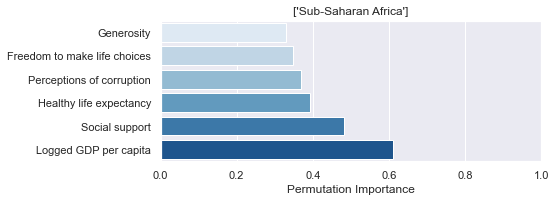

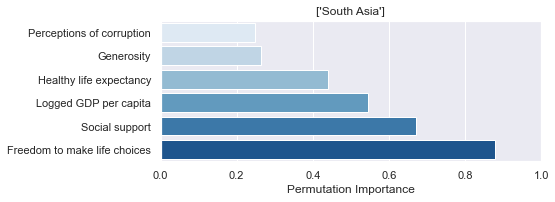

In [84]:

Regions = country_region['Regional indicator'].unique()


i=1
for reg in Regions :
        
        Region = df_full_score[df_full_score['Regional indicator'] == reg]

        name_region = Region['Regional indicator'][:1].values
        X_region = Region[col_feat]
        y_region = Region['Ladder score']

        X_region_scaled = scaler.transform(X_region)

        model.fit(X_region_scaled, y_region)

        perm_importance = permutation_importance(model, X_region_scaled, y_region, n_repeats=10, random_state=0)

        features = np.array(col_feat)

        sorted_idx = perm_importance.importances_mean.argsort()
        
        plt.subplot(5,2,i)
        sns.set(rc={"figure.figsize":(15, 15)})
        
        ax=sns.barplot(x = perm_importance.importances_mean[sorted_idx],y = features[sorted_idx] , palette = "Blues", orient='h')
        ax.set_xlim(left=0, right=1)
        plt.xlabel("Permutation Importance")
        plt.title(name_region)
        i += 1
        plt.show();
        